<a href="https://colab.research.google.com/github/iam-pattan/SRGANs/blob/main/SRGAN_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Exploration: [Code](https://colab.research.google.com/drive/1qAESW4TFW9Z20PIWEZIF--oT8T2py5kW#scrollTo=M_8g1J4MIIT0)

`Dataset`

https://www.kaggle.com/jessicali9530/celeba-dataset

https://github.com/OlafenwaMoses/IdenProf/releases/download/v1.0/idenprof-jpg.zip


In [ ]:
import glob
import os

import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize
import tensorflow as tf
from keras import Input
from keras.applications.vgg19 import VGG19
from keras.layers import BatchNormalization, Activation, LeakyReLU, Add, Dense, PReLU, Flatten
from keras.layers.convolutional import Conv2D, UpSampling2D
from keras.models import Model
from keras.optimizers import Adam
# from keras.callbacks import TensorBoard
# from scipy.misc import imsave

In [ ]:
## State-of-art(SOA) model data
# import tensorflow_datasets as tfds
# # from tfds.image.CelebA
# ds = tfds.load('celeb_a', split='train', shuffle_files=True)

In [ ]:
def residual_block(x):
    """
    Residual block
    """
    filters = [64, 64]
    kernel_size = 3
    strides = 1
    padding = "same"
    momentum = 0.8
    activation = "relu"

    res = Conv2D(filters=filters[0], kernel_size=kernel_size, 
                 strides=strides, padding=padding)(x)
    res = Activation(activation=activation)(res)
    res = BatchNormalization(momentum=momentum)(res)

    res = Conv2D(filters=filters[1], kernel_size=kernel_size, 
                 strides=strides, padding=padding)(res)
    res = BatchNormalization(momentum=momentum)(res)

    # Add res and x
    res = Add()([res, x])
    return res

In [ ]:
def build_generator():
    """
    Create a generator network using the hyperparameter values defined below
    :return:
    """
    residual_blocks = 16
    momentum = 0.8
    input_shape = (64, 64, 3)

    # Input Layer of the generator network
    input_layer = Input(shape=input_shape)

    # Add the pre-residual block
    gen1 = Conv2D(filters=64, kernel_size=9, strides=1, padding='same',  
                  activation='relu')(input_layer)

    # Add 16 residual blocks
    res = residual_block(gen1)
    for i in range(residual_blocks - 1):
        res = residual_block(res)

    # Add the post-residual block
    gen2 = Conv2D(filters=64, kernel_size=3, strides=1, padding='same')(res)
    gen2 = BatchNormalization(momentum=momentum)(gen2)

    # Take the sum of the output from the pre-residual block(gen1) and the post-residual block(gen2)
    gen3 = Add()([gen2, gen1])

    # Add an upsampling block
    gen4 = UpSampling2D(size=2)(gen3)
    gen4 = Conv2D(filters=256, kernel_size=3, strides=1, padding='same')(gen4)
    gen4 = Activation('relu')(gen4)

    # Add another upsampling block
    gen5 = UpSampling2D(size=2)(gen4)
    gen5 = Conv2D(filters=256, kernel_size=3, strides=1, 
                  padding='same')(gen5)
    gen5 = Activation('relu')(gen5)

    # Output convolution layer
    gen6 = Conv2D(filters=3, kernel_size=9, strides=1, padding='same')(gen5)
    output = Activation('tanh')(gen6)

    # Keras model
    model = Model(inputs=[input_layer], outputs=[output], 
                  name='generator')
    return model

In [ ]:
def build_discriminator():
    """
    Create a discriminator network using the hyperparameter values defined below
    :return:
    """
    leakyrelu_alpha = 0.2
    momentum = 0.8
    input_shape = (256, 256, 3)

    input_layer = Input(shape=input_shape)

    # Add the first convolution block
    dis1 = Conv2D(filters=64, kernel_size=3, strides=1, padding='same')(input_layer)
    dis1 = LeakyReLU(alpha=leakyrelu_alpha)(dis1)

    # Add the 2nd convolution block
    dis2 = Conv2D(filters=64, kernel_size=3, strides=2, padding='same')(dis1)
    dis2 = LeakyReLU(alpha=leakyrelu_alpha)(dis2)
    dis2 = BatchNormalization(momentum=momentum)(dis2)

    # Add the third convolution block
    dis3 = Conv2D(filters=128, kernel_size=3, strides=1, padding='same')(dis2)
    dis3 = LeakyReLU(alpha=leakyrelu_alpha)(dis3)
    dis3 = BatchNormalization(momentum=momentum)(dis3)

    # Add the fourth convolution block
    dis4 = Conv2D(filters=128, kernel_size=3, strides=2, padding='same')(dis3)
    dis4 = LeakyReLU(alpha=leakyrelu_alpha)(dis4)
    dis4 = BatchNormalization(momentum=0.8)(dis4)

    # Add the fifth convolution block
    dis5 = Conv2D(256, kernel_size=3, strides=1, padding='same')(dis4)
    dis5 = LeakyReLU(alpha=leakyrelu_alpha)(dis5)
    dis5 = BatchNormalization(momentum=momentum)(dis5)

    # Add the sixth convolution block
    dis6 = Conv2D(filters=256, kernel_size=3, strides=2, padding='same')(dis5)
    dis6 = LeakyReLU(alpha=leakyrelu_alpha)(dis6)
    dis6 = BatchNormalization(momentum=momentum)(dis6)

    # Add the seventh convolution block
    dis7 = Conv2D(filters=512, kernel_size=3, strides=1, padding='same')(dis6)
    dis7 = LeakyReLU(alpha=leakyrelu_alpha)(dis7)
    dis7 = BatchNormalization(momentum=momentum)(dis7)

    # Add the eight convolution block
    dis8 = Conv2D(filters=512, kernel_size=3, strides=2, padding='same')(dis7)
    dis8 = LeakyReLU(alpha=leakyrelu_alpha)(dis8)
    dis8 = BatchNormalization(momentum=momentum)(dis8)

    # Add a dense layer
    dis9 = Dense(units=1024)(dis8)
    dis9 = LeakyReLU(alpha=0.2)(dis9)

    # Last dense layer - for classification
    output = Dense(units=1, activation='sigmoid')(dis9)

    model = Model(inputs=[input_layer], outputs=[output], name='discriminator')
    return model

In [ ]:
def build_adversarial_model(generator, discriminator, vgg):

    input_low_resolution = Input(shape=(64, 64, 3))

    fake_hr_images = generator(input_low_resolution)
    fake_features = vgg(fake_hr_images)

    discriminator.trainable = False

    output = discriminator(fake_hr_images)

    model = Model(inputs=[input_low_resolution],
                  outputs=[output, fake_features])

    for layer in model.layers:
        print(layer.name, layer.trainable)

    print(model.summary())
    return model

In [ ]:
!wget 'https://github.com/OlafenwaMoses/IdenProf/releases/download/v1.0/idenprof-jpg.zip'
!unzip '/content/idenprof-jpg.zip'

Streaming output truncated to the last 5000 lines.
  inflating: idenprof/train/firefighter/firefighter-47.jpg  
  inflating: idenprof/train/firefighter/firefighter-470.jpg  
  inflating: idenprof/train/firefighter/firefighter-471.jpg  
  inflating: idenprof/train/firefighter/firefighter-472.jpg  
  inflating: idenprof/train/firefighter/firefighter-473.jpg  
  inflating: idenprof/train/firefighter/firefighter-474.jpg  
  inflating: idenprof/train/firefighter/firefighter-475.jpg  
  inflating: idenprof/train/firefighter/firefighter-476.jpg  
  inflating: idenprof/train/firefighter/firefighter-477.jpg  
  inflating: idenprof/train/firefighter/firefighter-478.jpg  
  inflating: idenprof/train/firefighter/firefighter-479.jpg  
  inflating: idenprof/train/firefighter/firefighter-48.jpg  
  inflating: idenprof/train/firefighter/firefighter-480.jpg  
  inflating: idenprof/train/firefighter/firefighter-481.jpg  
  inflating: idenprof/train/firefighter/firefighter-482.jpg  
  inflating: idenprof

In [ ]:
# Define hyperparameters
data_dir = '/content/idenprof/train/chef/*.*'
epochs = 20000
batch_size = 1

# Shape of low-resolution and high-resolution images
low_resolution_shape = (64, 64, 3)
high_resolution_shape = (256, 256, 3)

In [ ]:
# Common optimizer for all networks
common_optimizer = Adam(0.0002, 0.5)


## Build and Compiling model

In [ ]:
def build_vgg():
  # load model without output layer
  new_input = Input(shape=high_resolution_shape)
  model = VGG19(include_top=False, input_tensor=new_input)
  return model

In [ ]:
vgg = build_vgg()
vgg.trainable = False
vgg.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

80150528/80134624 [==============================] - 1s 0us/step


In [ ]:
discriminator = build_discriminator()
discriminator.compile(loss='mse', optimizer=common_optimizer, metrics=['accuracy'])

In [ ]:
generator = build_generator()

In [ ]:
input_high_resolution = Input(shape=high_resolution_shape)
input_low_resolution = Input(shape=low_resolution_shape)

In [ ]:
generated_high_resolution_images = generator(input_low_resolution)

In [ ]:
features = vgg(generated_high_resolution_images)

In [ ]:
discriminator.trainable = False

In [ ]:
probs = discriminator(generated_high_resolution_images)

In [ ]:
adversarial_model = Model([input_low_resolution, input_high_resolution], [probs, features])
adversarial_model.compile(loss=['binary_crossentropy', 'mse'], 
            loss_weights=[1e-3, 1], optimizer=common_optimizer)

In [ ]:
M = build_adversarial_model(generator, discriminator, vgg)

input_6 True
generator True
discriminator False
vgg19 False
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
generator (Functional)          (None, 256, 256, 3)  2042691     input_6[0][0]                    
__________________________________________________________________________________________________
discriminator (Functional)      (None, 16, 16, 1)    5219137     generator[1][0]                  
__________________________________________________________________________________________________
vgg19 (Functional)              (None, 8, 8, 512)    20024384    generator[1][0]                  
Total params: 27,286,212
Trainab

In [ ]:
# generator.summary()
# discriminator.summary()
# adversarial_model.summary()

In [ ]:
# import time
# tensorboard = TensorBoard(log_dir="logs/".format(time.time()))
# tensorboard.set_model(generator)
# tensorboard.set_model(discriminator)

In [ ]:
# for epoch in range(epochs):
#     print("Epoch:{}".format(epoch))

## model function

In [ ]:
def sample_images(data_dir, batch_size, high_resolution_shape, low_resolution_shape):
    # Make a list of all images inside the data directory
    all_images = glob.glob(data_dir)

    # Choose a random batch of images
    images_batch = np.random.choice(all_images, size=batch_size)

    low_resolution_images = []
    high_resolution_images = []

    for img in images_batch:
        # Get an ndarray of the current image
        img1 = plt.imread(img)
        img1 = img1.astype(np.float32)

        # Resize the image
        img1_high_resolution = resize(img1, high_resolution_shape)
        img1_low_resolution = resize(img1, low_resolution_shape)

        # Do a random flip
        if np.random.random() < 0.5:
            img1_high_resolution = np.fliplr(img1_high_resolution)
            img1_low_resolution = np.fliplr(img1_low_resolution)

        high_resolution_images.append(img1_high_resolution)
        low_resolution_images.append(img1_low_resolution)

    return np.array(high_resolution_images), np.array(low_resolution_images)

In [ ]:
def save_images(low_resolution_image, original_image, generated_image, path):
    """
    Save low-resolution, high-resolution(original) and
    generated high-resolution images in a single image
    """
    fig = plt.figure()
    ax = fig.add_subplot(1, 3, 1)
    ax.imshow(low_resolution_image)
    ax.axis("off")
    ax.set_title("Low-resolution")

    ax = fig.add_subplot(1, 3, 2)
    ax.imshow(original_image)
    ax.axis("off")
    ax.set_title("Original")

    ax = fig.add_subplot(1, 3, 3)
    ax.imshow(generated_image)
    ax.axis("off")
    ax.set_title("Generated")

    plt.savefig(path)

In [ ]:
data_dir = '/content/idenprof/train/Police/*.*'
all_images = glob.glob(data_dir)
np.random.choice(all_images, size=batch_size)

array(['/content/idenprof/train/police/police-352.jpg'], dtype='<U55')

In [ ]:
high_resolution_images, low_resolution_images = sample_images(data_dir=data_dir, 
                                                              batch_size=batch_size,
                                                              low_resolution_shape=low_resolution_shape, 
                                                              high_resolution_shape=high_resolution_shape)

In [ ]:
high_resolution_images = high_resolution_images / 127.5 - 1.
low_resolution_images = low_resolution_images / 127.5 - 1.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(<matplotlib.axes._subplots.AxesSubplot at 0x7fb69539a2d0>,
 <matplotlib.image.AxesImage at 0x7fb6953abb50>)

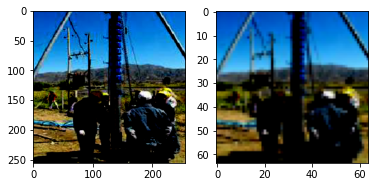

In [ ]:
plt.subplot(121), plt.imshow(high_resolution_images[0])
plt.subplot(122), plt.imshow(low_resolution_images[0])

In [ ]:
data_dir = '/content/idenprof/train/*/*.*'
epochs = 3000
batch_size = 1

# Shape of low-resolution and high-resolution images
low_resolution_shape = (64, 64, 3)
high_resolution_shape = (256, 256, 3)

# Common optimizer for all networks
common_optimizer = Adam(0.0002, 0.5) 

In [ ]:
!mkdir /content/results

Epoch:0
d_loss: [1.56604012e-04 1.00000000e+00]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


g_loss: [0.09336402267217636, 0.07535747438669205, 0.09328866750001907]
Epoch:1
d_loss: [1.4291445e-05 1.0000000e+00]
g_loss: [0.10117781162261963, 0.0879470556974411, 0.10108986496925354]
Epoch:2
d_loss: [6.73818977e-06 1.00000000e+00]
g_loss: [0.10386647284030914, 0.043648116290569305, 0.10382282733917236]
Epoch:3
d_loss: [3.40760175e-06 1.00000000e+00]
g_loss: [0.09772893786430359, 0.04283446446061134, 0.09768610447645187]
Epoch:4
d_loss: [6.60546466e-05 1.00000000e+00]
g_loss: [0.08642403036355972, 0.11439724266529083, 0.08630963414907455]
Epoch:5
d_loss: [2.93387202e-05 1.00000000e+00]
g_loss: [0.06575147062540054, 0.11365784704685211, 0.06563781201839447]
Epoch:6
d_loss: [9.65281697e-06 1.00000000e+00]
g_loss: [0.11071223765611649, 0.09248672425746918, 0.11061975359916687]
Epoch:7
d_loss: [9.22184518e-06 1.00000000e+00]
g_loss: [0.11925680190324783, 0.08297383040189743, 0.11917382478713989]
Epoch:8
d_loss: [1.65911548e-04 1.00000000e+00]
g_loss: [0.09982431679964066, 0.0725951790

KeyboardInterrupt: ignored

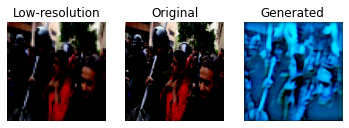

In [ ]:
for epoch in range(epochs):
  print("Epoch:{}".format(epoch))

  """
  Train the discriminator network
  """

  # Sample a batch of images
  high_resolution_images, low_resolution_images = sample_images(data_dir=data_dir, batch_size=batch_size,
                                                                low_resolution_shape=low_resolution_shape,
                                                                high_resolution_shape=high_resolution_shape)
  # Normalize images
  high_resolution_images = high_resolution_images / 127.5 - 1.
  low_resolution_images = low_resolution_images / 127.5 - 1.

  # Generate high-resolution images from low-resolution images
  generated_high_resolution_images = generator.predict(low_resolution_images)

  # Generate batch of real and fake labels
  real_labels = np.ones((batch_size, 16, 16, 1))
  fake_labels = np.zeros((batch_size, 16, 16, 1))

  # Train the discriminator network on real and fake images
  d_loss_real = discriminator.train_on_batch(high_resolution_images, real_labels)
  d_loss_fake = discriminator.train_on_batch(generated_high_resolution_images, fake_labels)

  # Calculate total discriminator loss
  d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
  print("d_loss:", d_loss)

  """
  Train the generator network
  """

  # Sample a batch of images
  high_resolution_images, low_resolution_images = sample_images(data_dir=data_dir, batch_size=batch_size,
                                                                low_resolution_shape=low_resolution_shape,
                                                                high_resolution_shape=high_resolution_shape)
  # Normalize images
  high_resolution_images = high_resolution_images / 127.5 - 1.
  low_resolution_images = low_resolution_images / 127.5 - 1.

  # Extract feature maps for real high-resolution images
  image_features = vgg.predict(high_resolution_images)

  # Train the generator network
  g_loss = adversarial_model.train_on_batch([low_resolution_images, high_resolution_images],
                                    [real_labels, image_features])

  print("g_loss:", g_loss)
  if epoch % 100 == 0:
    high_resolution_images, low_resolution_images = sample_images(data_dir=data_dir, batch_size=batch_size,
                                                                  low_resolution_shape=low_resolution_shape,
                                                                  high_resolution_shape=high_resolution_shape)
    # Normalize images
    high_resolution_images = high_resolution_images / 127.5 - 1.
    low_resolution_images = low_resolution_images / 127.5 - 1.

    generated_images = generator.predict_on_batch(low_resolution_images)

    for index, img in enumerate(generated_images):
        save_images(low_resolution_images[index], high_resolution_images[index], img,
                    path="results/img_{}_{}".format(epoch, index))

# Save models
generator.save_weights("generator.h5")
discriminator.save_weights("discriminator.h5")

In [ ]:
# Build and compile the discriminator network
discriminator = build_discriminator()

# Build the generator network
generator = build_generator()

# Load models
generator.load_weights("/content/generator.h5")
discriminator.load_weights("/content/discriminator.h5")

# Get 10 random images
high_resolution_images, low_resolution_images = sample_images(data_dir=data_dir, batch_size=10,
                                                              low_resolution_shape=low_resolution_shape,
                                                              high_resolution_shape=high_resolution_shape)
# Normalize images
high_resolution_images = high_resolution_images / 127.5 - 1.
low_resolution_images = low_resolution_images / 127.5 - 1.

# Generate high-resolution images from low-resolution images
generated_images = generator.predict_on_batch(low_resolution_images)

# Save images
for index, img in enumerate(generated_images):
    save_images(low_resolution_images[index], high_resolution_images[index], img,
                path="results/gen_{}".format(index))

In [ ]:
high_resolution_shape = (256,256,3)
img_1 = plt.imread('/content/idenprof/train/chef/chef-350.jpg')
image_high_resolution = resize(img_1, (512,512,3))
plt.subplot(121), plt.imshow(img_1)
plt.subplot(122), plt.imshow(image_high_resolution)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


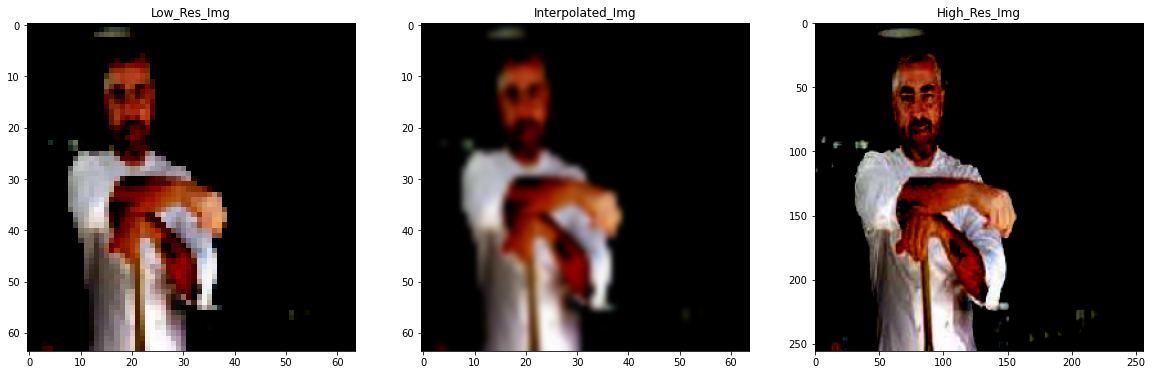

In [ ]:
plt.rcParams['figure.figsize'] = (20,12)
plt.subplot(132), plt.imshow(low_resolution_images[0], interpolation='bicubic')
plt.title('Interpolated_Img')
plt.subplot(131), plt.imshow(low_resolution_images[0])
plt.title('Low_Res_Img')
plt.subplot(133), plt.imshow(high_resolution_images[0])
plt.title('High_Res_Img')
plt.show()